In [ ]:
using LinearAlgebra
using Plots
using Printf
using SparseArrays

# **Heisenberg model Exact Diagonalization (Considering System symmetry)**

In [ ]:
function Heisenberg_ED(n)
    
    ###############
    # Parameters
    ###############
    
    N = n; # Number of spins
    J = 1; #Coupling constant
    h = 1; #External field strength
    
    #Pauli matrices:
    s_z = [1 0;0 -1]/2;
    s_p = [0 1; 0 0]/2;
    s_m = [0 0; 1 0]/2;
    Id = [1 0 ; 0 1];
    
    s_z = sparse(s_z);
    s_p = sparse(s_p);
    s_m = sparse(s_m);
    Id = sparse(Id);
    Sz =  Dict();
    Sp =  Dict();
    Sm =  Dict();
    I_others = 1;
    
    #####################################
    #   Construction of Spin operators
    #####################################
    
    t_operators = @elapsed begin
    for i=1:N
        Sz[i] = kron(I_others,s_z)
        Sp[i] = kron(I_others,s_p)
        Sm[i] = kron(I_others,s_m)
        I_others = kron(I_others,Id)

        for j=1:i-1
            Sz[j] = kron(Sz[j],Id)
            Sp[j] = kron(Sp[j],Id)
            Sm[j] = kron(Sm[j],Id)
        end

        for j=i+1:N
            Sz[j] = I_others
            Sp[j] = I_others
            Sm[j] = I_others
        end
    end
    end
    
    ######################################################## 
    #  Construction of Many-body Hamiltonian matrix & Lz
    ########################################################
    
    sum_time  = @elapsed begin
    H = spzeros(2^N, 2^N) #Hamiltonian
    H = -h*Sz[N]
    
    Lz = spzeros(2^N, 2^N) #Angular momentum in z-direction
    Lz = Sz[N]; 
    
    #Sum over all sites:
    for i=1:N-1
        H  = -J * (Sz[i]*Sz[i + 1] + 0.5 * (Sp[i]*Sm[i + 1] + Sm[i]*Sp[i + 1])) - h*Sz[i] + H
        Lz = Sz[i]+Lz
    end
    H = (H + H')/2; #Making sure Hamiltonian is hermitian
    end
    
    ###############
    # First method:                                
    ########################################################
    # Exact digonalization for the entire Hamiltonian matrix
    ########################################################
    
    total_diag_time = @elapsed begin
    Energy, State = eigen(Matrix(H));
    Energy = sort(Energy); #Energy spectrum from first method (ED for H)
    end
    
    ###########################################################################################################
    #  Sorting Lz and Permuting Hamiltonian with sorted indices (Using System Symmetry to block diagonalize H)
    ###########################################################################################################
    
    transformation_time = @elapsed begin
    Lz_diag = diag(Lz);
    Lz_sorted = sort(Lz_diag);
    s2 = sortperm(Lz_diag); #indices after sorting Lz_diag
     
    U = spzeros(2^N, 2^N) # U is Transformation matrix
    for i=1:2^N
        U[s2[i], i] = 1
    end
        
    #Basis Transformation:
    H_sorted = U'*H*U;
    end
    
    ########################
    # Block diagonalization
    ########################
    
    block_diag_time = @elapsed begin
    #Calculating size of each block by counting how many times each number is repeated in Lz 
    u = (unique(Lz_sorted)) #Lz values
    d = Dict([(i,count(x->x==i,Lz_sorted)) for i in u]) #Counts Lz values
    
    d_new = zeros(N+1);
    c = 1
    for i in u
        d_new[c] = (d[i])
        c=c+1
    end
    pop!(d_new)
    popfirst!(d_new)
    
    first = 2
    Energy_Block_Diag = [] #Energy spectrum from second method 
    
    
    for i in d_new
        last = first + Int(i) -1
        En_BD,S_BD  = eigen(Matrix(H_sorted[first:last,first:last])) #diagonalizing each block
        append!(Energy_Block_Diag, En_BD)
        first = last + 1
    end
    
    #the first and last elements in H_sorted are single numbers
    append!(Energy_Block_Diag, H_sorted[1,1])
    append!(Energy_Block_Diag, H_sorted[2^N,2^N])
    Energy_Block_Diag = sort(Energy_Block_Diag)
    end
    
    ####################
    # Calculating Time
    ####################
    First_Time =  t_operators + sum_time + total_diag_time
    Second_Time = t_operators + sum_time + transformation_time + block_diag_time
    
    return Energy_Block_Diag, Energy, H_sorted, First_Time,Second_Time
end

Heisenberg_ED (generic function with 1 method)

# N = 8

In [ ]:
En_BD8, En8, H_sorted8, block_diag_time8, total_diag_time8 = Heisenberg_ED(8);

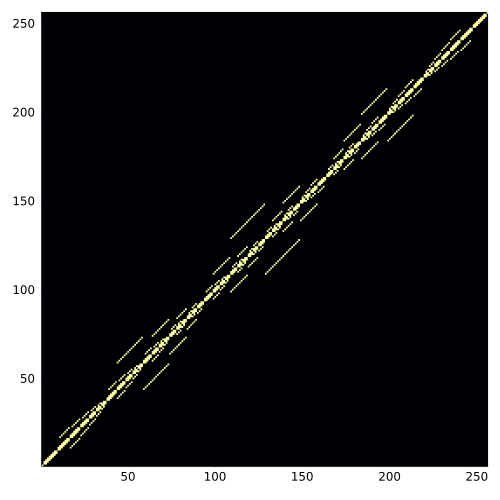

In [ ]:
H_plot8 = Matrix(H_sorted8)
H_plot8[H_plot8.!=0] .=1;
heatmap(H_plot8[1:256,1:256],legend = false,size = (500, 500))

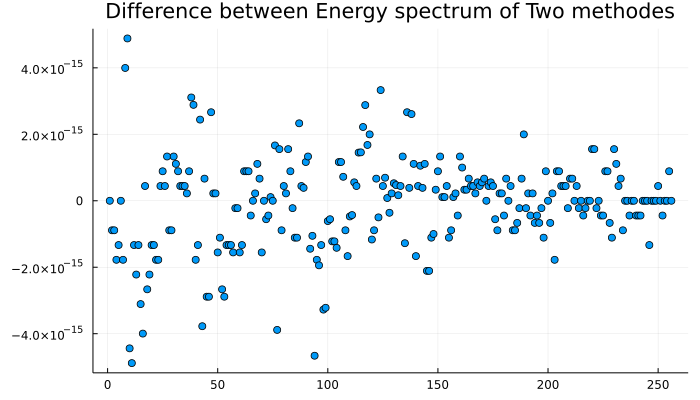

In [ ]:
#The Difference between Energy spectrum obtained from each method (Diagonalizing the Entire H and Diagonalizing each block)
Difference8 = (En_BD8 - En8)
scatter(Difference8 ,legend = false,size = (700, 400))
title!("Difference between Energy spectrum of Two methodes")

In [ ]:
@printf("After Taking sum over the entire spectrum the Difference between two methodes is %s",sum(Difference8))

After Taking sum over the entire spectrum the Difference between two methodes is -2.8130275886439904e-14

In [ ]:
# Comparind Energy values of two methods (true if they are equal)
En_BD8 ≈ En8

true

In [ ]:
Time_difference8 = (total_diag_time8 - block_diag_time8) 
@printf("conserved time is %s", Time_difference8)

conserved time is 0.07169326100000006

In [ ]:
Ground_state1 = En8[1]
Ground_state2 = En_BD8[1]
@printf("Ground state Energy in first method = %s \n" , Ground_state1)
@printf("Ground state Energy in first method = %s  " ,Ground_state2)

Ground state Energy in first method = -5.75 
Ground state Energy in first method = -5.75  

# N = 12

In [ ]:
En_BD12, En12, H_sorted12, block_diag_time12, total_diag_time12 = Heisenberg_ED(12);

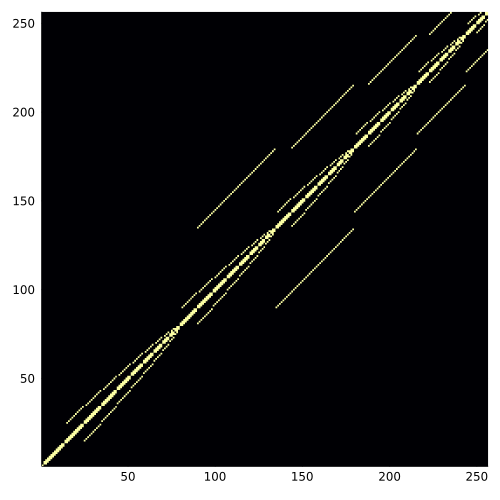

In [ ]:
H_plot12 = Matrix(H_sorted12)
H_plot12[H_plot12.!=0] .=1;
heatmap(H_plot12[1:256,1:256],legend = false,size = (500, 500))

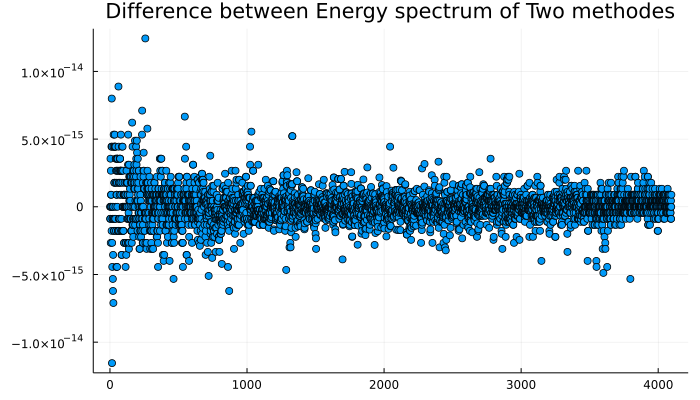

In [ ]:
#The Difference between Energy spectrum obtained from each method (Diagonalizing the Entire H and Diagonalizing each block)
Difference12 = (En_BD12 - En12)
scatter(Difference12 ,legend = false,size = (700, 400))
title!("Difference between Energy spectrum of Two methodes")

In [ ]:
@printf("After Taking sum over the entire spectrum the Difference between two methodes is %s",sum(Difference12))

After Taking sum over the entire spectrum the Difference between two methodes is 1.0611585395114975e-13

In [ ]:
# Comparing Energy values of two methods (true if they are equal)
En_BD12 ≈ En12

true

In [ ]:
Time_difference12 = -(total_diag_time12 - block_diag_time12) 
@printf("conserved time is %s", Time_difference12)

conserved time is 23.882791467

In [ ]:
Ground_state1 = En12[1]
Ground_state2 = En_BD12[1]
@printf("Ground state Energy in first method = %s \n" , Ground_state1)
@printf("Ground state Energy in first method = %s  " ,Ground_state2)

Ground state Energy in first method = -8.75 
Ground state Energy in first method = -8.75  